In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from numpy import array
from numpy import argmax
from keras.utils import to_categorical
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import sys
from numpy import load
from matplotlib import pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras import backend
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from keras.optimizers import SGD, Adam
from keras.models import Model
from tensorflow.keras import regularizers
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.applications.mobilenet_v2 import preprocess_input, MobileNetV2

In [ ]:
df=pd.read_csv("/90days/s4634945/files/UntitledFolder/CNN_dataframe_gene_expression_3.csv")
df_test=pd.read_csv("/90days/s4634945/files/UntitledFolder/CNN_dataframe_gene_expression_test_3.csv")
df['Cluster'] = df['Cluster'].astype('str')
df_test['Cluster']= df_test['Cluster'].astype('str')
datagen=ImageDataGenerator(rescale=1./255,validation_split = 0.2, featurewise_center=True,
            featurewise_std_normalization=True,
            rotation_range=0)
            #width_shift_range=0.2,
            #height_shift_range=0.2,
            #horizontal_flip=True,
            #vertical_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255,featurewise_center=True)
train_generator=datagen.flow_from_dataframe(dataframe=df, directory="/90days/s4634945/files/UntitledFolder/Sharpened_1A", x_col="Image", y_col="Cluster", class_mode="categorical", target_size=(290,290), batch_size=16, subset="training")
valid_generator = datagen.flow_from_dataframe(dataframe=df, directory="/90days/s4634945/files/UntitledFolder/Sharpened_1A", x_col="Image", y_col="Cluster", class_mode="categorical", target_size=(290,290), batch_size=16, subset="validation")
test_generator = test_datagen.flow_from_dataframe(dataframe=df_test, directory="/90days/s4634945/files/UntitledFolder/Trainimg_breast_test_299", x_col="Image", y_col="Cluster", class_mode="categorical", target_size=(290,290), batch_size=32)

In [ ]:
'''
model = Sequential([
    
    # First convolution
        Conv2D(16, (3,3), activation='relu', input_shape=(290,290, 3), kernel_regularizer=regularizers.l2(0.02)),
        #Conv2D(16, (3,3), activation='relu'),
        MaxPooling2D(2, 2),
    
    # Second convolution
        Conv2D(32, (3,3), activation='relu', kernel_regularizer=regularizers.l2(0.02)),
        #Conv2D(32, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        BatchNormalization(),
    
    # Third convolution
        Conv2D(64, (3,3), activation='relu', kernel_regularizer=regularizers.l2(0.02)),
        #Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),
       

    
    # Fourth convolution
        Conv2D(128, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        BatchNormalization(),
    
        Flatten(),
    
    # Dense hidden layer
        Dense(128, activation='relu'),
        Dropout(0.5),
 
    # Output neuron. 
        Dense(3, activation='softmax')])

'''

model = MobileNetV2(include_top=False, input_shape=(290,290,3), weights = "imagenet")
        
flat1 = Flatten()(model.layers[-1].output)

output = Dense(3, activation='softmax')(flat1)
model = Model(inputs=model.inputs, outputs=output)
opt = Adam(learning_rate=0.00001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
history = model.fit(train_generator,validation_data=valid_generator,epochs=5)

In [ ]:
import matplotlib.pyplot as plt
def plot_training(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b')
    plt.plot(epochs, val_acc, 'r')
    plt.title('Training and validation accuracy')

    plt.show()
    
plot_training(history)

In [ ]:
model.summary()

In [ ]:
import h5py
from keras.models import load_model 
#model.save('Scratch_model_1')
model = load_model("Scratch_model_1") 
#print(loaded_model.evaluate(test_generator))

In [ ]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input, decode_predictions
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2

model = model 

img = image.load_img('/90days/s4634945/files/UntitledFolder/Trainimg_breast_2_299/1000img.tif', target_size=(290,290))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
#print(decode_predictions(predicted_vals[0,:]))
with tf.GradientTape() as tape:
    last_conv_layer = model.get_layer('max_pooling2d_7')
    iterate = tf.keras.models.Model([model.inputs], [model.output, last_conv_layer.output])
    model_out, last_conv_layer = iterate(x)
    class_out = model_out[:, np.argmax(model_out[0])]
    grads = tape.gradient(class_out, last_conv_layer)
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
heatmap = heatmap.reshape((16,16))
plt.matshow(heatmap)
plt.show()

In [ ]:
from keras.preprocessing import image
def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
        img = image.load_img(img_path, target_size=(290, 290))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        #x = inet_model.preprocess_input(x)
        out.append(x)
    return np.vstack(out)

In [ ]:
import os
from keras.applications.imagenet_utils import decode_predictions
images = transform_img_fn([os.path.join('/90days/s4634945/files/UntitledFolder/Trainimg_breast_2_299','0032img.tif')])
plt.imshow(images[0])
preds = model.predict(images)

In [ ]:
%%time
%load_ext autoreload
%autoreload 2
import os,sys
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # add the current directory
    import lime
from lime import lime_image
explainer = lime_image.LimeImageExplainer()
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(images[0].astype('double'), model.predict, top_labels=3, hide_color=0, num_samples=3)

In [ ]:
from skimage.segmentation import mark_boundaries
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=100, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

In [ ]:
ind =  explanation.top_labels[0]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()

In [ ]:
import os
from keras.applications.imagenet_utils import decode_predictions
images = transform_img_fn([os.path.join('/90days/s4634945/files/UntitledFolder/Trainimg_breast_2_299','1000img.tif')])
plt.imshow(images[0])
preds = model.predict(images)

In [ ]:
%%time
%load_ext autoreload
%autoreload 2
import os,sys
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # add the current directory
    import lime
from lime import lime_image
explainer = lime_image.LimeImageExplainer()
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(images[0].astype('double'), model.predict, top_labels=3, hide_color=0, num_samples=3)

In [ ]:
ind =  explanation.top_labels[0]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()

In [ ]:
import os
from keras.applications.imagenet_utils import decode_predictions
images = transform_img_fn([os.path.join('/90days/s4634945/files/UntitledFolder/Trainimg_breast_2_299','0055img.tif')])
plt.imshow(images[0])
preds = model.predict(images)

In [ ]:
%%time
%load_ext autoreload
%autoreload 2
import os,sys
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # add the current directory
    import lime
from lime import lime_image
explainer = lime_image.LimeImageExplainer()
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(images[0].astype('double'), model.predict, top_labels=3, hide_color=0, num_samples=3)

In [ ]:
ind =  explanation.top_labels[0]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()

In [ ]:
plt.imsave('/90days/s4634945/files/UntitledFolder/LIME/Fibrous/Low/54_0.png',heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer
def multiclass_roc_auc_score(truth, pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(truth)
    truth = lb.transform(truth)
    pred = lb.transform(pred)
    return roc_auc_score(truth, pred, average=average)

preds = model.predict(test_generator)
test_pred = np.argmax(preds, axis=1)
cm = confusion_matrix(df_test['Cluster'].astype('int64'), test_pred)
print('Confusion matrix\n\n', cm)
classifier_report = classification_report(df_test['Cluster'].astype('int64'), test_pred)
print(classifier_report)
multiclass_roc_score = multiclass_roc_auc_score(df_test['Cluster'].astype('int64'), test_pred, average="weighted")
print("Multiclass_roc_score")
print(multiclass_roc_score)
logloss = log_loss(df_test['Cluster'].astype('int64'), preds)
print(logloss)

# Bayesian CNN

In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
dist = tfp.distributions
tfpl = tfp.layers
import time
from PIL import Image
import glob

In [3]:
image_paths = sorted(glob.glob("K_2_breast_train299/*.png"))
images_ = [np.array(Image.open(im)) for im in image_paths]
images_ = np.array(images_) # convert list of images to single array [(126,126,1)] --> (836, 126, 126, 1)
print(images_.shape)


train_Y = pd.read_csv('train_Y.csv')
train_Y = train_Y.sort_values(by='Sno')
train_Y = train_Y.reset_index(drop=True)
labels = train_Y['COX6C']

(3798, 290, 290, 4)


In [9]:
tf.keras.backend.clear_session()

kl_divergence_function = lambda q, p, _: dist.kl_divergence(q, p) / tf.cast(3798, dtype=tf.float32)

model = tf.keras.Sequential([
    tf.keras.Input(shape=(290,290,4),name="rocket"),
    
    tfp.layers.Convolution2DFlipout(16, kernel_size=5, strides=(3,3), data_format="channels_last", 
                                    padding="same", activation=tf.nn.relu, name="conv_tfp_1a", 
                                    kernel_divergence_fn=kl_divergence_function),
    tf.keras.layers.MaxPool2D(strides=(4,4), pool_size=(4,4), padding="same"),
    
    tfp.layers.Convolution2DFlipout(32, kernel_size=3, strides=(3,3), data_format="channels_last", 
                                    padding="same", activation=tf.nn.relu, name="conv_tfp_1b", 
                                    kernel_divergence_fn=kl_divergence_function),
    tf.keras.layers.MaxPool2D(strides=(4,4), pool_size=(4,4), padding="same"),
    
    tfp.layers.Convolution2DFlipout(64, kernel_size=3, strides=(3,3), data_format="channels_last", 
                                    padding="same", activation=tf.nn.relu, name="conv_tfp_1c", 
                                    kernel_divergence_fn=kl_divergence_function),
    tf.keras.layers.MaxPool2D(strides=(4,4), pool_size=(4,4), padding="same"),

    tf.keras.layers.Flatten(),
    tfp.layers.DenseFlipout(1, kernel_divergence_fn=kl_divergence_function),
])

learning_rate = 1.0e-3
model.compile(loss='mse',
              optimizer=tf.keras.optimizers.Adam(learning_rate),
              metrics=['mse'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_tfp_1a (Conv2DFlipout)  (None, 97, 97, 16)        3216      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 25, 25, 16)        0         
_________________________________________________________________
conv_tfp_1b (Conv2DFlipout)  (None, 9, 9, 32)          9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 32)          0         
_________________________________________________________________
conv_tfp_1c (Conv2DFlipout)  (None, 1, 1, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 64)                0

In [8]:
from tensorflow.keras.optimizers import Adam

def negative_log_likelihood(y_true, y_pred):
    return -y_pred.log_prob(y_true)

model.compile(loss = negative_log_likelihood,
              optimizer = Adam(learning_rate=0.005),
              metrics = ['accuracy'],
              experimental_run_tf_function = False)

In [10]:
batch_size = 16
history = model.fit(x=images_, 
                    y=np.array(labels),
                    epochs=25, 
                    verbose=1, 
                    batch_size=batch_size,
                    validation_split=0.1,
                    validation_freq=5)

Epoch 1/25
214/214 [==============================] - 24s 100ms/step - loss: 98992.7328 - mse: 98976.3130
Epoch 2/25
214/214 [==============================] - 21s 99ms/step - loss: 87908.6213 - mse: 87892.1991
Epoch 3/25
214/214 [==============================] - 20s 92ms/step - loss: 76270.1634 - mse: 76253.7546
Epoch 4/25
214/214 [==============================] - 19s 87ms/step - loss: 76007.3583 - mse: 75990.9574
Epoch 5/25
214/214 [==============================] - 23s 108ms/step - loss: 70314.2749 - mse: 70297.8887 - val_loss: 36345.9531 - val_mse: 36329.5703
Epoch 6/25
214/214 [==============================] - 20s 94ms/step - loss: 67791.9027 - mse: 67775.5350
Epoch 7/25
214/214 [==============================] - 22s 104ms/step - loss: 67518.3744 - mse: 67501.9893
Epoch 8/25
214/214 [==============================] - 21s 99ms/step - loss: 63181.9380 - mse: 63165.5537
Epoch 9/25
214/214 [==============================] - 21s 99ms/step - loss: 64836.9579 - mse: 64820.5865
Epoch 1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


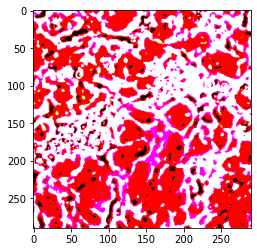

In [42]:
from keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
import numpy as np
import matplotlib.pyplot as plt
def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
        img = image.load_img(img_path, target_size=(290, 290))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        out.append(x)
    return np.vstack(out)
import os
from keras.applications.imagenet_utils import decode_predictions
images = transform_img_fn([os.path.join('Trainimg_breast_2_299','0074img.tif')])
plt.imshow(images[0]/2 + 0.5)
preds = model.predict(images)

In [43]:
%%time
%load_ext autoreload
%autoreload 2
import os,sys
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # add the current directory
    import lime
from lime import lime_image
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(images[0].astype('double'), model.predict, top_labels=1, hide_color=0, num_samples=1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


  0%|          | 0/1 [00:00<?, ?it/s]

Wall time: 2.24 s


C:\Users\Onkar\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


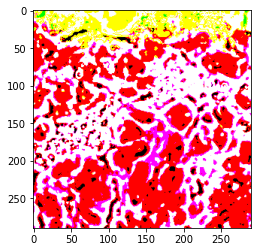

In [49]:
from skimage.segmentation import mark_boundaries
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=100, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

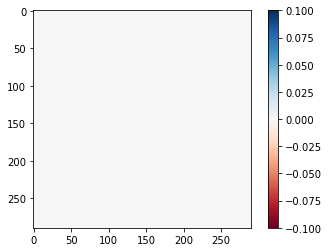

In [50]:
ind =  explanation.top_labels[0]
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()

# Tansfer Learning

In [62]:
import pandas as pd
train_Y= pd.read_csv('train_Y.csv')
train_Y = train_Y.sort_values(by='Sno')
train_Y = train_Y.reset_index(drop=True)
train_Y.drop(columns=['Unnamed: 0'], inplace=True)
train_Y['Sno'] = train_Y['Sno'] + str(".tif")

datagen=ImageDataGenerator(rescale=1./255, validation_split = 0.2, featurewise_center=True,
            featurewise_std_normalization=False,
            rotation_range=90,
            width_shift_range=0.2,
            height_shift_range=0.2,
            horizontal_flip=True,
            vertical_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255,featurewise_center=True)
train_generator=datagen.flow_from_dataframe(dataframe=train_Y, directory="Trainimg_breast_2_299", x_col="Sno", y_col="COX6C", class_mode="raw", target_size=(290,290), batch_size=32, subset="training")
valid_generator = datagen.flow_from_dataframe(dataframe=train_Y, directory="Trainimg_breast_2_299", x_col="Sno", y_col="COX6C", class_mode="raw", target_size=(290,290), batch_size=32, subset="validation")
#test_generator = test_datagen.flow_from_dataframe(dataframe=df_test, directory="Trainimg_breast_test_299", x_col="Image", y_col="Cluster", class_mode="categorical", target_size=(290,290), batch_size=32)

Found 3039 validated image filenames.
Found 759 validated image filenames.


In [ ]:
model = Sequential([
    
    # First convolution
        Conv2D(16, (3,3), activation='relu', input_shape=(290, 290, 3), kernel_regularizer=regularizers.l2(0.02)),
        Conv2D(16, (3,3), activation='relu'),
        MaxPooling2D(2, 2),
    
    # Second convolution
        Conv2D(32, (3,3), activation='relu'),
        Conv2D(32, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        #BatchNormalization(),
    
    # Third convolution
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        #BatchNormalization(),

    
    # Fourth convolution
        Conv2D(128, (3,3), activation='relu'),
        MaxPooling2D(2,2),
    
    # Fifth Convolution
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),
    
        Flatten(),
    
    # Dense hidden layer
        Dense(64, activation='relu'),
        Dropout(0.5),
    
    # Output neuron. 
        Dense(1) 
])

model.compile(loss='mse',
              optimizer='adam',
              metrics=['mse'])

history = model.fit(train_generator,validation_data=valid_generator,epochs=5)

In [ ]:
model = InceptionV3(include_top=False, input_shape=(290,290,3), weights = "imagenet")
flat1 = Flatten()(model.layers[-1].output)
dense = Dense(256, activation='relu')(flat1)
drop = Dropout(0.5)(dense)
output = Dense(2, activation='softmax')(drop)
model = Model(inputs=model.inputs, outputs=output)

model.compile(loss='mse',
              optimizer='adam',
              metrics=['mse'])

history = model.fit(train_generator,validation_data=valid_generator,epochs=5)

# Capsule Net

In [ ]:
import numpy as np
import tensorflow as tf

In [ ]:
input_image = tf.placeholder(shape = [None,290,290,3], dtype = float32)
conv1 = tf.layers.conv2D(input_image, 10, kernel_size = 9, stride=1,padding=“)
conv1 = tf.layer.conv2D(activation= ‘relu’)
conv2 = tf.layers.conv2D(input_image, 256, kernel_size = 9, stride=2,padding=“none”)
conv2 = tf.layer.conv2D(activation= ‘relu’)
capsule_1= tf.reshape(conv2,[-1,1152,8]) 

In [ ]:
def squash(s, name=None): 
with tf.name_scope(name, default_name="squash"): 
squared_norm = tf.reduce_sum(tf.square(s), axis=-1,     keep_dims=True)
safe_norm = tf.sqrt(squared_norm + 1e-7)
squash_factor = squared_norm / (1. + squared_norm) unit_vector = s / safe_norm return squash_factor * unit_vector
caps1_out = squash(capsule_1)

In [ ]:
W_init = tf.random_normal(shape=(1, caps1_n_caps, caps2_n_caps, caps2_n_dims, caps1_n_dims), stddev=init_sigma, dtype=tf.float32, name="W_init") W = tf.Variable(W_init, name="W")

batch_size = tf.shape(X)[0] W_tiled = tf.tile(W, [batch_size, 1, 1, 1, 1], name="W_tiled")

In [ ]:
caps1_output_enlarge = tf.expand_dims(caps1_output, -1)
caps1_output_tile = tf.expand_dims(caps1_output_expanded)
caps1_output_tiled = tf.tile(caps1_output_tile, [1, 1, caps2_n_caps, 1, 1])

print(W_tiled)
print(caps1_output_tiled)

In [ ]:
caps2_predicted = tf.matmul(W_tiled, caps1_output_tiled)
print(caps2_predicted)

In [ ]:
raw_weights = tf.zeros([batch_size, caps1_n_caps, caps2_n_caps, 1, 1], dtype=np.float32, name="raw_weights")

routing_weights = tf.nn.softmax(raw_weights, dim=2, name="routing_weights")

weighted_predictions = tf.multiply(routing_weights, caps2_predicted, name="weighted_predictions") weighted_sum = tf.reduce_sum(weighted_predictions, axis=1, keep_dims=True, name="weighted_sum")


Round 2 Routing: 


caps2_output_round_1_tiled = tf.tile( caps2_output_round_1, [1, caps1_n_caps, 1, 1, 1], name="caps2_output_round_1_tiled")

agreement = tf.matmul(caps2_predicted, caps2_output_round_1_tiled, transpose_a=True, name="agreement")

raw_weights_round_2 = tf.add(raw_weights, agreement, name="raw_weights_round_2")

routing_weights_round_2 = tf.nn.softmax(raw_weights_round_2, dim=2, name="routing_weights_round_2")

weighted_predictions_round_2 = tf.multiply(routing_weights_round_2, caps2_predicted, name="weighted_predictions_round_2") 

weighted_sum_round_2 = tf.reduce_sum(weighted_predictions_round_2, axis=1, keep_dims=True, name="weighted_sum_round_2") 

caps2_output_round_2 = squash(weighted_sum_round_2, axis=-2, name="caps2_output_round_2")


 y = tf.placeholder(shape=[None], dtype=tf.int64, name="y")

In [ ]:
m_plus = 0.9
m_minus = 0.1
lambda_ = 0.5 

T = tf.one_hot(y, depth=caps2_n_caps, name="T")

caps2_output_norm = safe_norm(caps2_output, axis=-2, keep_dims=True, name="caps2_output_norm")

present_error_raw = tf.square(tf.maximum(0., m_plus - caps2_output_norm), name="present_error_raw")

present_error = tf.reshape(present_error_raw, shape=(-1, 10), name="present_error")

absent_error_raw = tf.square(tf.maximum(0., caps2_output_norm - m_minus), name="absent_error_raw")

absent_error = tf.reshape(absent_error_raw, shape=(-1, 10), name="absent_error")

L = tf.add(T * present_error, lambda_ * (1.0 - T) * absent_error, name="L")

margin_loss = tf.reduce_mean(tf.reduce_sum(L, axis=1), name="margin_loss")

In [ ]:
mask_with_labels=tf.placeholder_with_default(False,shape=(),name="mask_with_labels")
reconstruction_targets = tf.cond(mask_with_labels, lambda: y, lambda: y_pred) 

Reconstruction_mask=tf.one_hot(reconstruction_targets,depth=caps2_n_caps,name="reconstruction_mask")

reconstruction_mask_reshaped=tf.reshape(reconstruction_mask,[-1,1,caps2_n_caps, 1, 1], name="reconstruction_mask_reshaped")

caps2_output_masked=tf.multiply(caps2_output,reconstruction_mask_reshaped,name="caps2_output_masked")

decoder_input=tf.reshape(caps2_output_masked,[-1,caps2_n_caps*caps2_n_dims], name="decoder_input")


With tf.name_scope("decoder"): 

hidden1=tf.layers.dense(decoder_input,512,activation=’relu’,name="hidden1")
          hidden2 = tf.layers.dense(hidden1,1024, activation=’relu’, name="hidden2") 
decoder_output=tf.layers.dense(hidden2,28X28,activation=’sigmoid’,name="decoder_output")


X_flat = tf.reshape(X, [-1, n_output], name="X_flat")

squared_difference=tf.square(X_flat-decoder_output,name="squared_difference") reconstruction_loss=tf.reduce_mean(squared_difference,name="reconstruction_loss")

loss = tf.add(margin_loss, 0.001 * reconstruction_loss, name="loss")

In [ ]:
n_epochs = 10
batch_size = 32
with tf.Session() as sess:
    if restore_checkpoint and tf.train.checkpoint_exists(checkpoint_path):
        saver.restore(sess, checkpoint_path)
    else:
        init.run()
    loss_vals = []
        acc_vals = []
        for iteration in range(1, n_iterations_validation + 1):
            X_batch, y_batch = mnist.validation.next_batch(batch_size)
            loss_val, acc_val = sess.run(
                    [loss, accuracy],
                    feed_dict={X: X_batch.reshape([-1, 28, 28, 1]),
                               y: y_batch})
            loss_vals.append(loss_val)
            acc_vals.append(acc_val)
            print("\rEvaluating the model: {}/{} ({:.1f}%)".format(
                      iteration, n_iterations_validation,
                      iteration * 100 / n_iterations_validation),
                  end=" " * 10)
        loss_val = np.mean(loss_vals)
        acc_val = np.mean(acc_vals)
        print("\rEpoch: {}  Val accuracy: {:.4f}%  Loss: {:.6f}{}".format(
            epoch + 1, acc_val * 100, loss_val)

In [ ]:
n_iterations_test = mnist.test.num_examples
loss_tests = []
acc_tests = []
for iteration in range(1, n_iterations_test + 1):
        X_batch, y_batch = mnist.test.next_batch(batch_size)
        loss_test, acc_test = sess.run(
                [loss, accuracy],
                feed_dict={X: X_batch.reshape([-1, 28, 28, 1]),
                           y: y_batch})
        loss_tests.append(loss_test)
        acc_tests.append(acc_test)
        print("\rEvaluating the model: {}/{} ({:.1f}%)".format(
                  iteration, n_iterations_test,
                  iteration * 100 / n_iterations_test),
              end=" " * 10)
    loss_test = np.mean(loss_tests)
    acc_test = np.mean(acc_tests)
    print("\rFinal test accuracy: {:.4f}%  Loss: {:.6f}".format(
        acc_test * 100, loss_test))

In [ ]:
sample_images = sample_images.reshape(-1, 28, 28)
reconstructions = decoder_output_value.reshape([-1, 28, 28])

plt.figure(figsize=(n_samples * 2, 3))
for index in range(n_samples):
    plt.subplot(1, n_samples, index + 1)
    plt.imshow(sample_images[index], cmap="binary")
    plt.title("Label:" + str(mnist.test.labels[index]))
    plt.axis("off")
plt.show()

plt.figure(figsize=(n_samples * 2, 3))
for index in range(n_samples):
    plt.subplot(1, n_samples, index + 1)
    plt.title("Predicted:" + str(y_pred_value[index]))
    plt.imshow(reconstructions[index], cmap="binary")
    plt.axis("off")
plt.show()

# Cancer vs Non-Cancer LIME